In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from IPython.display import SVG

from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau


In [2]:
data_dir = "./oct2017/OCT2017/"
train_data_dir= './oct2017/OCT2017/train/'
val_data_dir= './oct2017/OCT2017/val/'
test_data_dir= './oct2017/OCT2017/test/'

img_width, img_height = 150, 150 
channels = 3
batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [4]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83489 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [5]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

In [6]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg19 = VGG19(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
model = Sequential()

for layer in vgg19.layers:
    model.add(layer)

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

In [8]:
model.compile(optimizer= keras.optimizers.Adam(1e-5), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [9]:
checkpoint = ModelCheckpoint(
    'finetuned_model_last.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)


callbacks = [checkpoint, earlystop]

In [10]:
model.load_weights('finetuned_model_last.h5')

In [11]:
history_1 = model.fit(
    train_generator, 
    epochs = 25,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2609 steps, validate for 1 steps
Epoch 1/25
2608/2609 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.9006
Epoch 00001: loss improved from inf to 0.29163, saving model to finetuned_model_last.h5
2609/2609 [==============================] - 1165s 447ms/step - loss: 0.2915 - accuracy: 0.9006 - val_loss: 0.0942 - val_accuracy: 0.9688
Epoch 2/25
2608/2609 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9399
Epoch 00002: loss improved from 0.29163 to 0.17997, saving model to finetuned_model_last.h5
2609/2609 [==============================] - 1156s 443ms/step - loss: 0.1799 - accuracy: 0.9399 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 3/25
2608/2609 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9488
Epoch 00003: loss improved from 0.17997 to 0.15464, saving model to finetuned_model_last.h5
2609/2609 [==============================] - 1157s 443ms/step - l

2609/2609 [==============================] - 1159s 444ms/step - loss: 0.0477 - accuracy: 0.9834 - val_loss: 0.0199 - val_accuracy: 1.0000


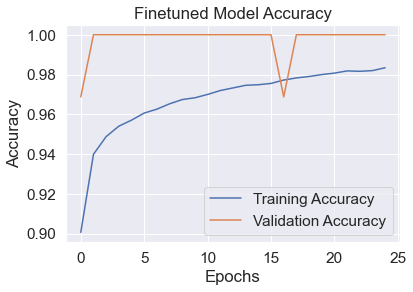

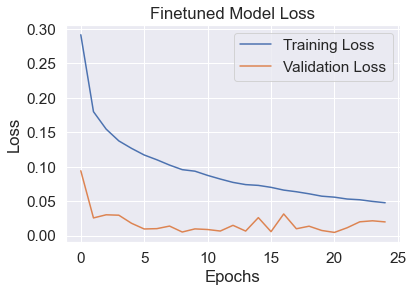

In [19]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch_last.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch_last.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [11]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

  ...
    to  
  ['...']
31/31 [==============================] - 10s 310ms/step - loss: 0.0371 - accuracy: 0.9917
Test Loss:  0.03709157686056635
Test Accuracy:  0.9917355


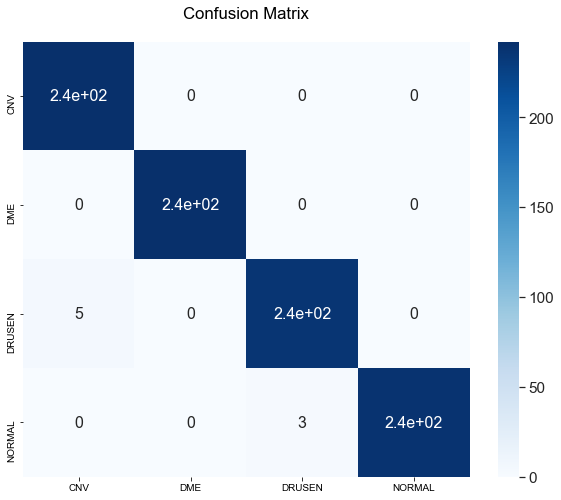

Classification Report of VGG-19 Architecture Model

              precision    recall  f1-score   support

         CNV       0.98      1.00      0.99       242
         DME       1.00      1.00      1.00       242
      DRUSEN       0.99      0.98      0.98       242
      NORMAL       1.00      0.99      0.99       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



In [12]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report of VGG-19 Architecture Model\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [13]:
test_X, test_Y = next(valid_test_datagen.flow_from_directory(
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= 968,        
    class_mode= 'categorical',
    shuffle= False, ))

test_y = np.argmax(test_Y, axis=1)

Found 968 images belonging to 4 classes.


In [14]:
Y_pred = model.predict(test_generator)
yhat_classes = model.predict_classes(test_X)

# kappa
kappa = cohen_kappa_score(test_y, yhat_classes)
print('Cohens kappa: %f' % kappa)


# ROC AUC
auc = roc_auc_score(test_Y, Y_pred)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.988981
ROC AUC: 0.999787


In [16]:
from prettytable import PrettyTable

pretty = PrettyTable()

pretty.field_names = ['Metrices','Values']

pretty.add_row(['Accuracy Testing', '0.9917'])
pretty.add_row(['ROC AUC', '0.9997'])
pretty.add_row(['Cohens Kappa', '0.9989'])
pretty.add_row(['Precision','0.99'])
pretty.add_row(['Recall','0.99'])
pretty.add_row(['F1-score','0.99'])

print(pretty)

+------------------+--------+
|     Metrices     | Values |
+------------------+--------+
| Accuracy Testing | 0.9917 |
|     ROC AUC      | 0.9997 |
|   Cohens Kappa   | 0.9989 |
|    Precision     |  0.99  |
|      Recall      |  0.99  |
|     F1-score     |  0.99  |
+------------------+--------+
